## RL algorithms

In [1]:
# HIDDEN
import gym
import time
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.size"] = 14

In [2]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR); # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### RL algorithms

- We used the PPO algorithm for almost the entire course (except offline RL)
- In fact, RLlib offers many algorithms! See [here](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html).
- Let's look at one more algorithm, DQN.

Notes:

There are over 20 algorithms at the time of recording.

#### Deep Q-Network (DQN)

- DQN is famous in the RL world for many breakthroughs such as the [Atari results](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) from 2013.
- In RLlib, we only need to make the smallest of swaps:

PPO:

In [3]:
from ray.rllib.algorithms.ppo import PPOConfig

ppo = PPOConfig().framework("torch").debugging(log_level="ERROR").build(env="FrozenLake-v1")

DQN:

In [4]:
from ray.rllib.algorithms.dqn import DQNConfig

dqn = DQNConfig().framework("torch").debugging(log_level="ERROR").build(env="FrozenLake-v1")

And that's it!

#### PPO vs. DQN on Frozen Lake

In [5]:
t = time.time()
ppo_results = []
for i in range(50):
    ppo_results.append( ppo.train()["episode_reward_mean"] )
print(f"Elapsed time {time.time()-t:.1f} s")

Elapsed time 144.8 s


In [6]:
t = time.time()
dqn_results = []
for i in range(50):
    dqn_results.append( dqn.train()["episode_reward_mean"] )
print(f"Elapsed time {time.time()-t:.1f} s")

Elapsed time 118.3 s


#### PPO vs. DQN on Frozen Lake

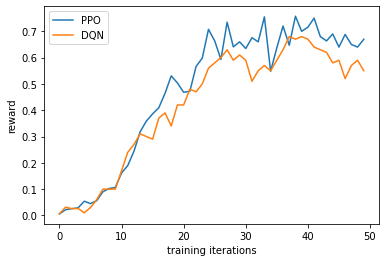

In [7]:
plt.plot(ppo_results, label="PPO")
plt.plot(dqn_results, label="DQN")
plt.legend();
plt.xlabel("training iterations");
plt.ylabel("reward");

- In this particular run of this case, the two algorithms seem to do about equally well.
- But, in general, one may be more suitable than the other.

Notes:

As in supervised learning, if you don't have domain expertise, an empirical approach is practical: try a few algorithms. PPO is a workhorse of RL, similar to something like a random forest or XGBoost in SL. That is why we focused on it in this course.

#### On-policy vs. off-policy

- Under the hood PPO and DQN work very differently
- PPO is an **on-policy** algorithm, DQN is **off-policy**
- This makes DQN more _sample efficient_ than PPO.
- They also have similarities, e.g. both are _model-free_ methods

Notes:

- PPO trains while running its own policy
- DQN can train on _experiences_ that may come from another policy (related to offline RL)
- DQN learns like offline RL (from data) but it continuously generates new data from the env
- Because DQN can learn from experiences, it can save up experiences and reuse them, meaning it can use the simulator less. This makes it more sample efficient. PPO is less sample efficient; by being on-policy it needs to be generating new data all the time to update the policy.

#### Q-values

- One big difference is that DQN directly learns _Q-values_
- For each state-action pair, a Q-value is a measure of "goodness" of taking that action.
- Let's take a look:

In [8]:
# HIDDEN
import utils

In [9]:
env = gym.make("FrozenLake-v1")
utils.get_q_state_action(dqn, env, 3) # See GitHub for the source code

array([-0.06429265, -0.10165626, -0.07749158,  0.05933957], dtype=float32)

Notes:

- The interpretation is _somewhat_ similar to the action probabilities we saw with PPO, but these values are _not_ probabilities.
- The above is consistent with what we saw in Module 2, where we saw the agent tries to move up towards the edge of the map in this situation (using PPO in that case).

#### Q-values

Here are the Q-values for all 16 possible observations:

In [10]:
q_sa = np.array([utils.get_q_state_action(dqn, env, i) for i in range(16)])
q_sa

array([[ 0.01178058, -0.01243308, -0.01992002, -0.02328416],
       [-0.07297245, -0.11419626, -0.10103753,  0.06659888],
       [-0.01738127, -0.03290066, -0.03224129, -0.00309269],
       [-0.06429265, -0.10165626, -0.07749158,  0.05933957],
       [ 0.1241755 , -0.05826544, -0.10803059, -0.07162949],
       [-0.0941615 , -0.01083766,  0.00750799, -0.02923728],
       [ 0.05468804, -0.04806233,  0.05219751, -0.1229748 ],
       [-0.04019574,  0.09429464, -0.00272179,  0.01204462],
       [-0.13350473, -0.11583142, -0.13849398,  0.10854381],
       [-0.03289278,  0.18439792, -0.02347143, -0.04941537],
       [ 0.11867873,  0.00533286, -0.06567188, -0.08079379],
       [-0.01257503,  0.00094413, -0.07582183,  0.07007836],
       [ 0.02402775,  0.00685143,  0.03579623, -0.06733035],
       [-0.16532828, -0.09951892,  0.14798597, -0.10628328],
       [-0.07862489,  0.11409644, -0.0382952 , -0.03409812],
       [-0.18762805, -0.09358893, -0.12985383, -0.04729923]],
      dtype=float32)

#### Q-values

We can plot these 64 (16x4) Q-values:

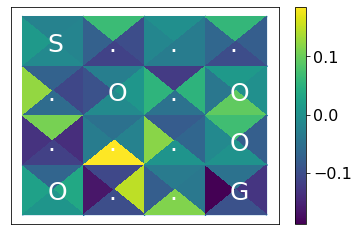

In [11]:
utils.q_state_action_plot_frozenlake(q_sa, env) # See GitHub for source code

We saw a similar plot in Module 2 with the PPO action probabilities.

Observations:

- We again see the desire to move up from the top-right.
- The strongest desire is to not die at square 10. Moving left is the only 100% safe move.
- Why move down at square 14? Because 13 is better than 10.
  - You can confirm that by scrolling back to the state Q-value plot.

#### State Q-values

There are also Q-values for each state, independent of actions. Let's turn out attention to these.

In [12]:
utils.get_q_state(dqn, env, 3) # See GitHub for the source code

0.2333979457616806

- Apparently the observation "3" (player at top-right) has a "value" of 0.16.
- The units of this "value" is expected discounted total reward.
  - Recall, we discussed discounting from Module 4!

With PPO, Q-values are not available:

In [13]:
utils.get_q_state(ppo, env, 3)

AttributeError: 'FullyConnectedNetwork' object has no attribute 'get_state_value'

Notes:

For Frozen Lake, all the values will be less than 1 because 1 is the maximum reward of an episode. Even if an agent is sure it will get to the end, the value will be less than 1 because of the discounting. 

Because of the discounting, we shouldn't interpret this 0.16 is a probability of reaching the goal.

#### Q-values

We can look at these for all 16 observations using a plot:

In [14]:
q_s = [utils.get_q_state(dqn, env, i) for i in range(16)]

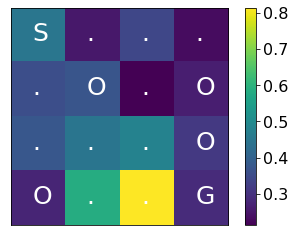

In [15]:
utils.q_state_plot_frozenlake(q_s, env) # See GitHub for the source code

- Let's loop back to what we saw in Module 2, that the agent wanted to move _down_ from location 14.
- Now we can see that state 10 has a lower value than state 14.
- So, although PPO doesn't explicitly represent a value function for each state, this may be the "logic".

Notes:
    
Here we see that the most desirable state is the one before the goal. We can also see that the states have higher Q values as they get nearer the goal. Remember that this is the slippery Frozen Lake, so winning isn't guaranteed and being closer to the goal is indeed better.

The Q-values for the end states (O and G) don't look particularly meaningful. 

#### Policy network internals

- In module 2 we used `query_policy` and here `get_q_state` and `get_q_state_action`.
- What do these functions actually look like?
- Here's `get_q_state`.

In [22]:
import torch
from ray.rllib.models.preprocessors import get_preprocessor 

def get_q_state(algo, env, obs):
    model = algo.get_policy().model
    prep = get_preprocessor(env.observation_space)(env.observation_space)
    model_output = model({"obs": torch.from_numpy(prep.transform(obs)[None])})[0]
    return float(model.get_state_value(model_output))

- Let's unpack this code step-by-step.
- FYI: these next few slides assume some familiarity with deep learning / neural networks.
- If this is not your cup of tea, feel free to skip them.

#### Policy network internals: model

In [48]:
model = dqn.get_policy().model

In [26]:
model

FullyConnectedNetwork_as_DQNTorchModel(
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=16, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (advantage_module): Sequential(
    (dueling_A_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (A): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=4, bias=True)
      )
    )
  )
  (value_module): Sequential(
    (dueling_V_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (V): 

Notes:

Here we see the internals of the policy network, which is a deep neural network implemented in pytorch. We can see the detals of the network like the hidden layers, activation functions (ReLU here), number of hidden units, etc.  

#### Policy network internals: preprocessor

In [27]:
prep = get_preprocessor(env.observation_space)(env.observation_space)

In [28]:
prep

- This is interesting. You may have encountered one-hot encoding in your DL or ML work.
- Recall our observation space is `Discrete(16)`.
  - And the observation is the input to a neural network.
- So, the observation is one-hot encoded by RLlib automatically.
- For example:

In [29]:
prep.transform(3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

#### Policy network internals: model output

The next line is:

In [34]:
obs = 3
model_output = model({"obs": torch.from_numpy(prep.transform(obs)[None])})[0]

1. The observation is one-hot encoded by the preprocessor.
2. The observation is cast from a numpy array to a pytorch tensor.
3. The tensor is passed into the neural network.

In [36]:
type(model_output)

torch.Tensor

In [37]:
model_output.shape

torch.Size([1, 256])

- This is the output right before the end of the network.
- The size would be different if we had set `fcnet_hiddens` to a different value in the config.

#### Policy network internals: Q-value

And finally:

In [41]:
float(model.get_state_value(model_output))

0.2333979457616806

- This is the Q-value for the observation 3.

Notes: 

Note that `get_state_value` is a built-in RLlib model method, unlike `get_q_state` or `query_policy` which were created separately for this course.

#### Policy network internals: state-action Q-values

The code to get state-action Q-values just differs at the last line:

In [46]:
model.get_q_value_distributions(model_output)[0].detach().numpy()[0]

array([-0.06429265, -0.10165626, -0.07749158,  0.05933957], dtype=float32)

Here we have a Q-value for each state-action pair, with the state set to 3 in this case.

#### Policy network internals: query policy

- The code for `query_policy` also uses the same initial lines of code.
- We want to use this on our PPO agent, though.

In [65]:
model = ppo.get_policy().model
prep = get_preprocessor(env.observation_space)(env.observation_space)
model_output = model({"obs": torch.from_numpy(prep.transform(obs)[None])})[0]

Notes:

We re-run those same initial lines but with our PPO agent.

#### Policy network internals: query policy

The rest of the code is as follows:

In [66]:
dist = policy.dist_class(model_output, model)

⬆️ Gets a class representing the distribution over actions

In [67]:
actions = torch.from_numpy(np.array([0,1,2,3]))

⬆️ Create a pytorch tensor containing the possible actions for Frozen Lake

In [68]:
logprobs = dist.logp(actions).detach().numpy()
logprobs

array([-2.5782592 , -0.9202799 , -2.8476949 , -0.75990987], dtype=float32)

⬆️ Get the log probabilities, convert from pytorch tensor to numpy array

In [69]:
probs = np.exp(logprobs)
probs

array([0.07590602, 0.3984075 , 0.05797781, 0.4677086 ], dtype=float32)

⬆️ Get the log probabilities, convert from pytorch tensor to numpy array

In [70]:
probs.sum()

0.9999999

⬆️ Looks right 😮‍💨

#### Beyond DQN

- There are many RL algorithms, and new ones are being invented every year!
- DQN: 2013, PPO: 2017, ...
- As with deep learning, RL as a field is moving fast.

#### Let's apply what we learned!

## PPO vs. DQN
<!-- multiple choice -->

Which is a better algorithm, PPO or DQN?

- [x] PPO is our recommended starting point for most problems, but DQN might be more suitable sometimes.
- [ ] DQN is our recommended starting point for most problems, but PPO might be more suitable sometimes.
- [ ] PPO is always a better choice than DQN.
- [ ] DQN is always a better choice than PPO.

## Switching algorithms in RLlib
<!-- multiple choice -->

How does one switch to a different RL algorithm in RLlib?

- [ ] In the config, change the `algo` parameter, e.g. `config.training(algo="DQN")
- [ ] Specify this when calling `.train()`, e.g. `algo.train("DQN")`
- [ ] Instantiate the base config for that algorithm, e.g. `DQNConfig()` instead of `PPOConfig()`
- [ ] To change RL algorithms, you need to switch to another package instead of RLlib

## TODO coding exercise 

In [16]:
# TODO: show the actual torch model? just one slide even?